# BGSE Summer School, July 2021: Supervised Machine Learning - Classification

In [1]:
# Load packages

# Basics
import re                                                               # built-in regular expressions
import os                                                               # built-in operating system interfaces
import numpy as np                                                      # for everything matrix-related
import pandas as pd                                                     # data manipulation and analysis
pd.set_option('display.max_columns', None)                              # Show all columns on display

# nltk
import nltk                                                             # Natural language Toolkit
from nltk.stem import SnowballStemmer                                   # Porter's II Stemmer
from nltk import word_tokenize                                          # Document tokenizer
from nltk.corpus import stopwords                                       # Importing stopwords

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt                                         # Plotting library
plt.style.use("ggplot")
import seaborn as sns                                                   # High-end plotting based on matplotlib

# sklearn
from sklearn.feature_extraction.text import TfidfVectorizer             # Convert raw documents to TF-IDF matrix of features
from pathlib import Path

# Misc
from tqdm import tqdm                                                   # Progress bar for loops
tqdm.pandas()
import scipy.stats as stats

In [2]:
# reproducibility
seed = 42
# python RNG
import random
random.seed(seed)
# numpy RNG
import numpy as np
np.random.seed(seed)

#### Get data, first inspection

In [3]:
basedir = Path(os.environ['SUMMER_SCHOOL']) / 'Day3'
datadir = basedir / 'data'
utildir = basedir / 'utils'
os.chdir(basedir)

In [4]:
COLS = [
    'date',
    'author',
    'title',
    'article',
    'section',
    'publication'
]

TYPES = {
    'date': str,
    'author': str,
    'title': str,
    'article': str,
    'section': str,
    'publication': str
}

In [6]:
reuters_df = pd.read_csv(
    datadir / 'reuters_news.csv',
    usecols=COLS,
    dtype=TYPES
)

reuters_df['words'] = reuters_df.article.str.len()

In [7]:
reuters_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25090 entries, 0 to 25089
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         25090 non-null  object
 1   author       10202 non-null  object
 2   title        25090 non-null  object
 3   article      25090 non-null  object
 4   section      25090 non-null  object
 5   publication  25090 non-null  object
 6   words        25090 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 1.3+ MB


In [8]:
reuters_df.head(2)

date      author                                              title  \
0  2019-12-12  Ian Ransom  Internationals inspired by video tips from '98...   
1  2017-04-07         NaN  BRIEF-Beijing Capital Development's Q1 contrac...   

                                             article      section publication  \
0  MELBOURNE (Reuters) - Tiger Woods’ Presidents ...  sports news     Reuters   
1  April 7 (Reuters) - Beijing Capital Developmen...   financials     Reuters   

   words  
0   2593  
1    319

In [9]:
pd.crosstab(reuters_df.section, reuters_df.publication)

publication      Reuters
section                 
commodities         5363
financials          4842
politics            5260
sports news         5545
technology news     4080

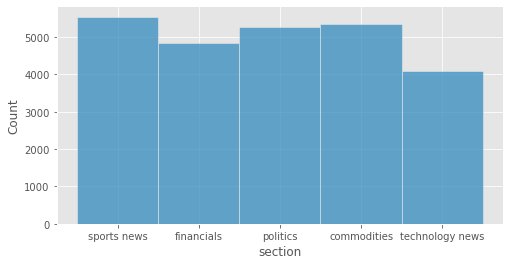

In [10]:
plt.figure(figsize=(8,4))
_ = sns.histplot(reuters_df, x="section")

In [18]:
word_distr = reuters_df.groupby('section').describe()

word_distr.style.format("{:,.0f}")

Text(0.5, 0.98, 'Word distribution over categories')

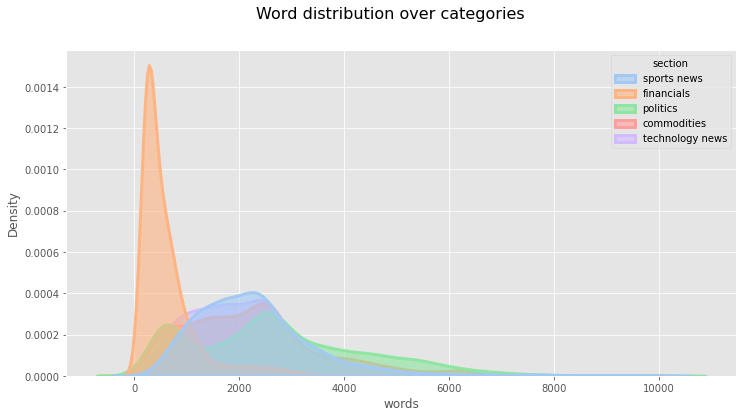

In [20]:
plt.figure(figsize=(12,6))
dist = sns.kdeplot(
   data=reuters_df, x="words", hue="section",
   fill=True, common_norm=False, palette="pastel",
   alpha=.6, linewidth=3,
)
dist.figure.suptitle("Word distribution over categories", fontsize = 16)

### Preprocessing

In [31]:
# Pre-processing steps
remove_punct = str.maketrans('','','!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~“”’—')
stop_words = stopwords.words('english')
stop_words.append('reuters')
stop_words.append('said')
stemmer = SnowballStemmer('english')

In [32]:
# Pre-processing function
def normalize_text(doc):
    """Takes documents as input and outputs clean tokens"""
    
    lower      = doc.lower()                                             # all lower case
    nopunc     = lower.translate(remove_punct)                           # remove punctuation
    words      = nopunc.split()                                          # split into tokens
    nostop     = [w if w not in stop_words else 'stopword' for w in words ]               # remove stopwords
    no_numbers = [w for w in nostop if not w.isdigit()]                  # normalize numbers
    stem_text  = [stemmer.stem(w) for w in no_numbers]                   # stem each word
    
    
    return stem_text

In [33]:
reuters_df = reuters_df.copy()

reuters_df['preproc'] = (
    reuters_df['article']
    .astype(str)
    .progress_apply(lambda row: normalize_text(row))
)

reuters_df['preproc'] = [' '.join(word) for word in reuters_df['preproc']]

100%|███████████████████████████████████████████████████████████████████████████| 25090/25090 [01:18<00:00, 318.43it/s]


### Wordclouds

In [51]:
from collections import Counter

cat_dict = {}

for item in reuters_df['section'].unique():
    tmp_ = reuters_df.loc[reuters_df.section==item]['preproc'].apply(lambda x: [b for b in list(map(' '.join, zip(x.split(' ')[:-1], x.split(' ')[1:])))])
    tmp_ = np.hstack(tmp_)
    cat_dict[item] = Counter(tmp_)
    
mapper = {}

for i, item in enumerate(list(cat_dict.keys())):
    mapper[i] = item

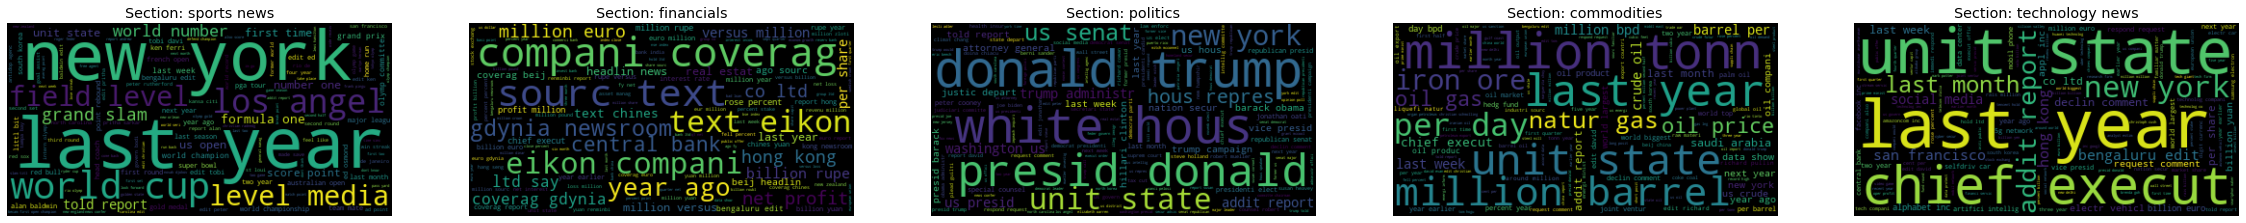

In [52]:
from wordcloud import WordCloud

fig, axes = plt.subplots(1, 5,figsize=(40,20))

for i, ax in enumerate(axes.flatten()):
    ax.set_title('Section: ' + str(mapper[i]))
    wordcloud = WordCloud().generate_from_frequencies(cat_dict[mapper[i]])

    # Plot resulting WordCloud
    ax.imshow(wordcloud, interpolation = 'bilinear')
    ax.axis('off')

## Supervised Machine Learning

### Train, test samples

In [41]:
from sklearn.model_selection import train_test_split

In [128]:
# train_test_split returns two dataframes
train_df, test_df = train_test_split(reuters_df, random_state=42, test_size=0.2)

train_x = train_df['preproc']
test_x = test_df['preproc']

train_y = train_df['section']
test_y = test_df['section']

### Feature weighting

Note the use of the <code>TfidfVectorizer</code> object in the code segment below. We first define the class object, and then use the *x_train* dataset to build the vocabulary and weighted frequency of words (ie, we call <code>.fit_transform</code>. We then use that same vocabulary to create a sparse matrix for *x_test*, but do not grow the vocabulary further (ie, we call <code>.transform</code>). 

In [129]:
#Get the TF-IDF vectors
tvec = TfidfVectorizer(analyzer     = 'word',      # Arg: feature as word (use analyzer to collapse all steps in the future!)
                       ngram_range  = (1, 1),      # Arg: a range of n-grams to extract as features 
                       stop_words   = None,        # Arg: stopwords (already removed above)
                       encoding     = "utf-8",     # Arg: Variable-width encoding
                       decode_error = "replace",   # Arg: Instruction to deal with non-UTF-8
#                        max_features = 9000,        # Arg: Maximum number of features (trick)
                       min_df       = 0.01,        # Arg: Minimum frequency of words-features
                       max_df       = 0.9          # Arg: Maximum frequency of words-features
                      )

train_data_tfidf = tvec.fit_transform(train_x)     # Train and transform  
test_data_tfidf = tvec.transform(test_x)

X_train_mat = train_data_tfidf.todense()           # Output in dense format
X_test_mat = test_data_tfidf.todense()             # Output in dense format

words = tvec.get_feature_names()                   # Store word names

# Data snippet
x_train_df = pd.DataFrame(X_train_mat)
x_train_df.columns = words
x_train_df.head(2)

10year   ab  abandon  abil  abl  abu  acceler  accept  access    accord  \
0     0.0  0.0      0.0   0.0  0.0  0.0      0.0     0.0     0.0  0.060052   
1     0.0  0.0      0.0   0.0  0.0  0.0      0.0     0.0     0.0  0.000000   

   account  accus  achiev  acquir  acquisit  acr  across  act  action  activ  \
0      0.0    0.0     0.0     0.0       0.0  0.0     0.0  0.0     0.0    0.0   
1      0.0    0.0     0.0     0.0       0.0  0.0     0.0  0.0     0.0    0.0   

   actual   ad  add  addit  address  adjust  administr  adopt  advanc  \
0     0.0  0.0  0.0    0.0      0.0     0.0        0.0    0.0     0.0   
1     0.0  0.0  0.0    0.0      0.0     0.0        0.0    0.0     0.0   

   advantag  advis  affair  affect  africa  african   ag  agenc  ago  agre  \
0       0.0    0.0     0.0     0.0     0.0      0.0  0.0    0.0  0.0   0.0   
1       0.0    0.0     0.0     0.0     0.0      0.0  0.0    0.0  0.0   0.0   

   agreement  agricultur  ahead  ahm  aim  air  aizhu   al  alberta  alexand  \
0        0.0         0.0    0.0  0.0  0.0  0.0    0.0  0.0      0.0      0.0   
1        0.0         0.0    0.0  0.0  0.0  0.0    0.0  0.0      0.0      0.0   

   alexandra  alleg  alli  allow  almost  alon  along  alreadi      also  \
0        0.0    0.0   0.0    0.0     0.0   0.0    0.0      0.0  0.050395   
1        0.0    0.0   0.0    0.0     0.0   0.0    0.0      0.0  0.000000   

   altern  although  aluminum  alway  america  american  amid  among  amount  \
0     0.0       0.0       0.0    0.0      0.0       0.0   0.0    0.0     0.0   
1     0.0       0.0       0.0    0.0      0.0       0.0   0.0    0.0     0.0   

   ana  analyst  anantharaman  andrew  andrey  anim   announc  annual  anoth  \
0  0.0      0.0           0.0     0.0     0.0   0.0  0.077073     0.0    0.0   
1  0.0      0.0           0.0     0.0     0.0   0.0  0.000000     0.0    0.0   

   anticip  antidump  appeal  appear  appetit  appli  applic  appoint  \
0      0.0       0.0     0.0     0.0      0.0    0.0     0.0      0.0   
1      0.0       0.0     0.0     0.0      0.0    0.0     0.0      0.0   

   approach  approv  approxim    april  arab  arabia  arbitr  area  argentina  \
0       0.0     0.0       0.0  0.07262   0.0     0.0     0.0   0.0        0.0   
1       0.0     0.0       0.0  0.00000   0.0     0.0     0.0   0.0        0.0   

   argu  arm  around  arrang  arriv  asia  asian  ask  assess  asset  associ  \
0   0.0  0.0     0.0     0.0    0.0   0.0    0.0  0.0     0.0    0.0     0.0   
1   0.0  0.0     0.0     0.0    0.0   0.0    0.0  0.0     0.0    0.0     0.0   

   assum  attack  attempt  attend  attract  attribut  auction  aug  august  \
0    0.0     0.0      0.0     0.0      0.0       0.0      0.0  0.0     0.0   
1    0.0     0.0      0.0     0.0      0.0       0.0      0.0  0.0     0.0   

   australia  australian  author  avail  averag  avoid  award  away  back  \
0        0.0         0.0     0.0    0.0     0.0    0.0    0.0   0.0   0.0   
1        0.0         0.0     0.0    0.0     0.0    0.0    0.0   0.0   0.0   

   bad  balanc  ban      bank  barrel  base  basi  basic  basin  batteri  \
0  0.0     0.0  0.0  0.057968     0.0   0.0   0.0    0.0    0.0      0.0   
1  0.0     0.0  0.0  0.000000     0.0   0.0   0.0    0.0    0.0      0.0   

   battl  becam     becom  began  begin  behind  beij  believ  belt  \
0    0.0    0.0  0.000000    0.0    0.0     0.0   0.0     0.0   0.0   
1    0.0    0.0  0.321748    0.0    0.0     0.0   0.0     0.0   0.0   

   benchmark  benefit  bengaluru  best  bet  better  beyond  bhp  bid  big  \
0        0.0      0.0        0.0   0.0  0.0     0.0     0.0  0.0  0.0  0.0   
1        0.0      0.0        0.0   0.0  0.0     0.0     0.0  0.0  0.0  0.0   

   bigger  biggest  bijan  bill  billion  billiton  blair  blame  blend  \
0     0.0      0.0    0.0   0.0      0.0       0.0    0.0    0.0    0.0   
1     0.0      0.0    0.0   0.0      0.0       0.0    0.0    0.0    0.0   

   block  board  bodi  bolster  bond  book  

## 1 - Logistic Regression

The first classifier we will look at is **logistic regression**, a linear classifier that solves a linear function $f(x) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_nx_n$, where the $x_i$ are variables (here, tf-idf weighted words) and $beta_i$ are its coefficients. The classifier solves the sigmoid function of $f(x)$, or:

$$
p(f(x))=\frac{1}{1+e^{-f(x)}}
$$

with values close to either 0 or 1 across most of its domain, as shown by the image:
<div style="text-align:center">
<img src="figs/sigmoid.png" alt="sigmoid" style="height: 300px; width:500px;"/>
</div>

Logistic regression estimates the predicted weights for the $\beta_i$ coefficients such that the $p(f(x))$ function is as close as possible to the actual target values, $y_i$. In other words, it minimizes a loss function of the distance between predictions and observations on our sample space. Solving for these optimal weights is what is generally knwon as model training or fitting, and in the case of binary classification problems these weights are solved by using maximum likelihood estimation on binary distributions.

Consider for example a logistic regression on a single variable, ie we have to predict whether we will like a coffee brand solely given it's level of roasting (which conveniently ranges from 0 to 10) given our past pattern of roast preferences. Then, the single-variable logistic regression can be represented as:

<div style="text-align:center">
<img src="figs/single-var_logit.png" alt="sigmoid" style="height: 300px; width:600px;"/>
</div>

in the above, green dots are previous observations we can use to train our binary classification model. Since we only have a single variable, our linear function reads $f(x) = \beta_0 + \beta_1 x_1$ and can be seen above as the dotted line that intersects the sigmoid function somewhere between 3 and 4. Fitting this function in $p(f(x))$, we can make a prediction that we will like a coffee if its roasting level is larger than 3.75. 

Note that in our text example we are dealing with multi-class classification. A quick solution is to iterate over binary classification problems, where in each iteration we classify whether an article is in a given section vs. being in any of all other sections (as a single alternative group). This method has certain drawbacks, but that's beyond the scope of the script.

#### A comment on regularization
Before we code in the Logistic Regression, it is worth mentioning that most applications of linear methods include some sort of regularization element. This is because in solving our minimization problem, the machine will attempt to reduce the loss using whatever information it has available, which includes not only the underlying relationships in your data but also the noise in your training sample. The corollary is that when using this information in previously unseen data, the performance of the model will suffer as idiosyncratic noise will be missing. In other words, while overperforming in your training data, overfitted models will underperform in your test data. 

Regularization attempts to tame such behavior by adding a penalization term on your objective function, which adds a bias towards less complex solutions to the optimization problem. If our previous problem (fitting coefficients to minimize prediction errors in our logistic regression) read:

$$
\underset{\beta}{\operatorname{minimize}} \sum_{x, y} L\left(\beta x, y\right)
$$

the addition of a penalization term can be seen as modifying our problem so that we instead solve:

$$
\underset{\beta}{\operatorname{minimize}} \sum_{x, y} L\left(\beta x, y\right) + \lambda g(\beta)
$$

where $g(\beta)$ is typically either the L1 norm (lasso) or the L2 (ridge). The difference between these is subtle and we won't go into detail, but a representation of it for $\beta=w$ is:

<div style="text-align:center">
<img src="figs/regularizations.gif" alt="sigmoid" style="height: 400px; width:600px;"/>
</div>

#### A comment on solving for our regression

To get the best weights (the best $\beta$) we will use maximum likelihood estimation, by which we maximize the log-likelihood function for all observations in our data set. Said differently, under distributional assumptions, we will assign coefficient weights in a way that our observed data is most probable. In the case of a logistic regression, the likelihood function to maximize looks as follows:

$$
\ell(\beta \mid y) \propto \prod_{i}\left(\frac{\exp \left(x_{i}^{\prime} \beta\right)}{1+\exp \left(x_{i}^{\prime} \beta\right)}\right)^{y_{i}}\left(\frac{1}{1+\exp \left(x_{i}^{\prime} \beta\right)}\right)^{1-y_{i}}
$$

The non-linearity of our equation makes a close-form solution not possible. This problem is common to most machine learning applications, and the solution is to gradually approximate a minimum (under a tolerance threshold) by iteratively differentiating your function and gradually inching towards a (hopefully) global minima. This process is normally known as [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) and we use it throughout this script.

Using sklearn's library, we can now finally move to the code behind a Logistic Regression. We begin by calling the corresponding module.

In [46]:
from sklearn.linear_model import LogisticRegression

import time

Next, we call the Logistic regression model. Note we can call in multiple solvers, but scikit's documentation explicitly mentions the SAGA solver is often the best choice. The SAGA solver is a variation of Stochastic Average Gradient, which optimizes over the sum of a finite number of smooth convex functions. While SAG originally only worked using L1 penalties, SAGA can use both L1 and L2 (and an ensemble of both).

#### Cross-Validation to find best parameters

In [49]:
from sklearn.model_selection import GridSearchCV

# Fine-tuning hyperparameters
grid = {
    "C": np.logspace(-2,2,5), 
    "penalty": ["l2"], 
    "solver": ['liblinear', 'saga']
}

model = LogisticRegression(solver='liblinear')       # Model to fit in each iteration of the gridsearch
model_cv = GridSearchCV(model, grid, cv=10)           # Define GridSearch class

model_cv.fit(X_train_mat,train_y)                    # Fit calculates parameters of the Logit in the GridSearch object

model_cv.get_params()                                # Print best model 

{'cv': 5,
 'error_score': nan,
 'estimator__C': 1.0,
 'estimator__class_weight': None,
 'estimator__dual': False,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1,
 'estimator__l1_ratio': None,
 'estimator__max_iter': 100,
 'estimator__multi_class': 'auto',
 'estimator__n_jobs': None,
 'estimator__penalty': 'l2',
 'estimator__random_state': None,
 'estimator__solver': 'liblinear',
 'estimator__tol': 0.0001,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': LogisticRegression(solver='liblinear'),
 'iid': 'deprecated',
 'n_jobs': None,
 'param_grid': {'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
  'penalty': ['l2']},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'verbose': 0}

#### Model definition

In [50]:
# Define Logit models

# Logistic Regression with L1 (lasso) penalization
scikit_log_reg_l1 = LogisticRegression(
    solver='saga',
    random_state=42, 
    C=1, 
    penalty='l1', 
    max_iter=1000
)

# Logistic Regression with L2 (lasso) penalization
scikit_log_reg_l2 = LogisticRegression(
    solver='saga',
    random_state=42, 
    C=1, 
    penalty='l2', 
    max_iter=1000
)

# Logistic Regression with elastic net (L1&L2) penalization
scikit_log_reg_ela = LogisticRegression(
    solver='saga',
    random_state=42, 
    C=1, 
    penalty='elasticnet', 
    l1_ratio = 0.5,
    max_iter=1000
)

# Fit our data to the models

#L1 → Measure time it takes to fit
start = time.time()
print('Fitting model with L1 regularization')
model_l1 = scikit_log_reg_l1.fit(X_train_mat, train_y)
end = time.time()
logit_l1_time = end - start
print('Time completion: %.2f seconds' % logit_l1_time)

#L2 → Measure time it takes to fit
start = time.time()
print('Fitting model with L2 regularization')
model_l2 = scikit_log_reg_l2.fit(X_train_mat, train_y)
end = time.time()
logit_l2_time = end - start
print('Time completion: %.2f seconds' % logit_l2_time)

#Elastic net → Measure time it takes to fit
start = time.time()
print('Fitting model with L1&L2 regularization')
model_ela = scikit_log_reg_ela.fit(X_train_mat, train_y)
end = time.time()
logit_ela_time = end - start
print('Time completion: %.2f seconds' % logit_ela_time)

Fitting model with L1 regularization
Time completion: 119.32 seconds
Fitting model with L2 regularization
Time completion: 20.59 seconds
Fitting model with L1&L2 regularization
Time completion: 51.16 seconds


It's worth briefly noting that the choice of solver is not trifling. Solvers have their strengths and weaknesses (see [here](https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-definitions)), and depending on your data (for example, likelihood of hitting local maxima vs. global maxima) some algorithms may be preferred over others. Another concern is that of speed. SAGA, while quite effective on large datasets, is by no means the fastest solver, and testing your model with different solvers is always encouraged. Visually, the rate at which solvers may approximate the optimum can greatly diverge from method to method:

<div style="text-align:center">
<img src="figs/contours.gif" alt="sigmoid" style="height: 400px; width:600px;"/>
</div>

#### Save models

### Accuracy scores

In [53]:
from sklearn import metrics

# Mean of correctly predicted labels across classes
logit_l1_score = model_l1.score(X_test_mat, test_y)   
logit_l2_score = model_l2.score(X_test_mat, test_y)
logit_ela_score = model_ela.score(X_test_mat, test_y)

print('L1 Model accuracy: %.3f' % logit_l1_score)
print('L2 Model accuracy: %.3f' % logit_l2_score)
print('Elastic Net Model accuracy: %.3f' % logit_ela_score)

L1 Model accuracy: 0.960
L2 Model accuracy: 0.957
Elastic Net Model accuracy: 0.958


### Confusion Matrix

In [54]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

model_dict = {
    0: {'model_l1': model_l1},
    1: {'model_l2': model_l2},
    2: {'model_ela': model_ela}
}

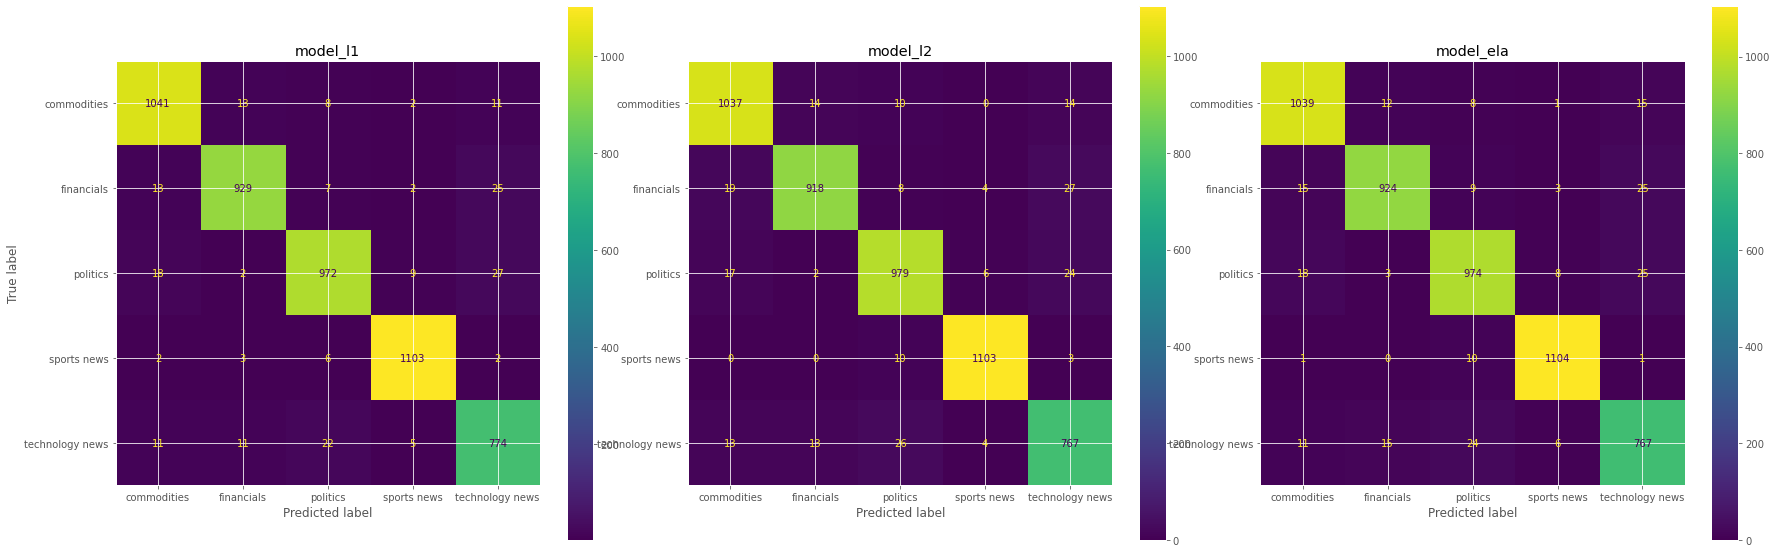

In [26]:
fig, axes = plt.subplots(1, 3,figsize=(24,8))
fig.tight_layout()

for i, ax in enumerate(axes.flatten()):
    model_name = list(model_dict[i].keys())[0]
    ax.set_title(model_name)
    cm = confusion_matrix(test_y, model_dict[i][model_name].predict(X_test_mat))
    cmp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=model_dict[i][model_name].classes_
    )
    cmp.plot(ax=ax)

#### Multiclass ROC curve

Receiver Operating Characteristic (ROC) curves are a measure of a classifier’s predictive quality that compares and visualizes the tradeoff between the models’ sensitivity and specificity. To explain these, consider the four possible outcomes in a binary classification exercise. 

<table>
<thead>
  <tr>
    <th rowspan="2">Test</th>
    <th colspan="4">Binary</th>
    <th rowspan="2">Total</th>
  </tr>
  <tr>
    <td>$Y_{true} = 1$</td>
    <td>n</td>
    <td>$Y_{true} = 0$</td>
    <td>n</td>
  </tr>
</thead>
<tbody>
  <tr>
    <td>Positive</td>
    <td>True Positive (TP)</td>
    <td>a</td>
    <td>False Positive&nbsp;&nbsp;&nbsp;(FP)</td>
    <td>c</td>
    <td>a + c</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>False Negative (FN)</td>
    <td>b</td>
    <td>True Negative (TN)</td>
    <td>d</td>
    <td>b + d</td>
  </tr>
  <tr>
    <td>Total</td>
    <td> </td>
    <td>a + b</td>
    <td> </td>
    <td>c + d</td>
    <td> </td>
  </tr>
</tbody>
</table>

- **Sensitivity**: probability that a test result will be positive when $y_{true}=1$ (true positive rate, expressed as a percentage). The _true positive rate_ is proportional to the sensitivity measure.

$$
\text { Sensitivity }=\frac{a}{a+b}
$$


- **Specificity**: probability that a test result will be negative when $y_{true}=0$ (true negative rate, expressed as a percentage). The _false positive rate_ is inversely proportional to the specificity measure.

$$
\text { Specificity }=\frac{d}{c+d}
$$

Additionally, you will often come accross a measure of **precision**, which in our example above corresponds to:

$$
\text { Recall }=\frac{a}{a+c}
$$

The ROC curve displays the _true positive rate_ on the Y axis and the _false positive rate_ on the X axis on both a global average and per-class basis, plotted for different classification thresholds. The ideal point is therefore the top-left corner of the plot: false positives are zero and true positives are one.

This leads to another metric, area under the curve (AUC), a computation of the relationship between false positives and true positives. The higher the AUC, the better the model generally is. However, it is also important to inspect the “steepness” of the curve, as this describes the maximization of the true positive rate while minimizing the false positive rate. 

ROC curves are typically used in binary classification, and in fact the Scikit-Learn roc_curve metric is only able to perform metrics for binary classifiers. As a result it is necessary to binarize the output or to use one-vs-rest or one-vs-all strategies of classification. 

To perform such transformation, we use yellowbrick, a fantastic python library for Machine learning visualization.

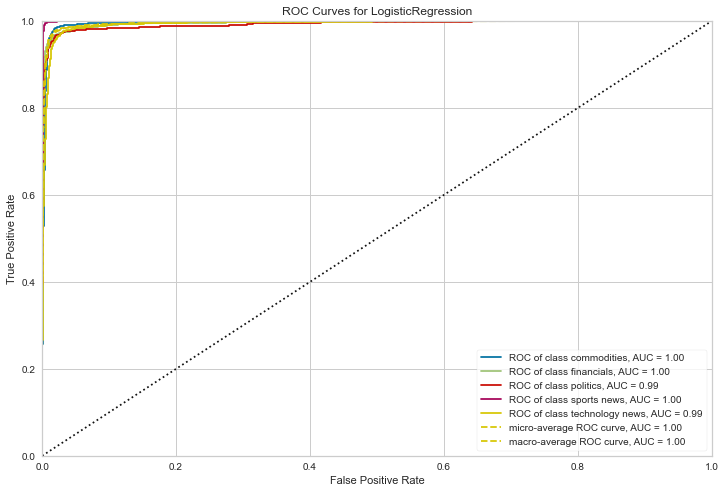

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [55]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

y = le.fit_transform(train_y)

from yellowbrick.classifier import ROCAUC
from yellowbrick.datasets import load_game

visualizer = ROCAUC(model_l1, classes=le.classes_)

plt.figure(figsize=(12,8))
visualizer.fit(X_train_mat, train_y)    # Fit the training data to the visualizer
visualizer.score(X_test_mat, test_y)    # Evaluate the model on the test data
visualizer.show()                       # Finalize and render the figure

### Precision-Recall curve

In [55]:
from yellowbrick.classifier import PrecisionRecallCurve

visualizer = PrecisionRecallCurve(model_l2, classes=le.classes_)

plt.figure(figsize=(12,8))
visualizer.fit(X_train_mat, train_y)    # Fit the training data to the visualizer
visualizer.score(X_test_mat, test_y)    # Evaluate the model on the test data
visualizer.show()                       # Finalize and render the figure

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\David\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-56-c18752ad35eb>", line 6, in <module>
    visualizer.fit(X_train_mat, train_y)    # Fit the training data to the visualizer
  File "C:\Users\David\AppData\Roaming\Python\Python38\site-packages\yellowbrick\classifier\prcurve.py", line 288, in fit
    return super(PrecisionRecallCurve, self).fit(X, Y)
  File "C:\Users\David\AppData\Roaming\Python\Python38\site-packages\yellowbrick\classifier\base.py", line 176, in fit
    super(ClassificationScoreVisualizer, self).fit(X, y, **kwargs)
  File "C:\Users\David\AppData\Roaming\Python\Python38\site-packages\yellowbrick\base.py", line 390, in fit
    self.estimator.fit(X, y, **kwargs)
  File "C:\Users\David\anaconda3\lib\site-packages\sklearn\multiclass.py", line 241, in fit
    self.estimators_ = Parallel(n_

TypeError: object of type 'NoneType' has no len()

<Figure size 864x576 with 0 Axes>

In [59]:
test = "News of the corruption probe sent stock markets tumbling as the S&P 500 dropped 300 points in thirty minutes."

test = ' '.join(normalize_text(test))

test = tvec.transform([test]).todense()

print(model_l1.predict(test))
model_l1.predict_proba(test)

['financials']


array([[0.10723193, 0.58604048, 0.05926061, 0.12122006, 0.12624692]])

In [30]:
test = "The screen is good for the money: fairly sharp, with good viewing angles, and bright enough indoors, though it struggles in direct sunlight. It also has Amazon’s integrated Alexa voice assistant."

test = ' '.join(normalize_text(test))

test = tvec.transform([test]).todense()

print(model_l1.predict(test))
model_l1.predict_proba(test)

['technology news']


array([[0.0911834 , 0.23789638, 0.07468197, 0.19098332, 0.40525493]])

In [31]:
test = "Southgate has ensured the defenders are well-drilled but what makes the England backline stand out is their communication and desire to play for one another. "

test = ' '.join(normalize_text(test))

test = tvec.transform([test]).todense()

print(model_l1.predict(test))
model_l1.predict_proba(test)

['sports news']


array([[0.03467665, 0.05675997, 0.02672304, 0.8171865 , 0.06465384]])

In [32]:
test = "When they poured across the border, I was cautioned to surrender, This I could not do, I took my gun and vanished."

test = ' '.join(normalize_text(test))

test = tvec.transform([test]).todense()

print(model_l1.predict(test))
model_l1.predict_proba(test)

['sports news']


array([[0.16454194, 0.2118469 , 0.12680175, 0.32426863, 0.17254078]])

#### Feature relevance

In [60]:
for i, class_ in enumerate(model_l1.classes_):
    top = model_l1.coef_[i].argsort()[::-1][:20]
    wds = ' '.join([words[i] for i in top])
    print(f'Most relevant features for section {class_}: {wds}')

Most relevant features for section commodities: oil commod barrel metal gas import gold refineri steel energi pipelin mine tonn compani capac crop soybean cargo plant price
Most relevant features for section financials: coverag nov feb aug oct sept dec text march jan june index bank april add newsroom eikon may rose benchmark
Most relevant features for section politics: trump washington democrat republican obama senat us hous secretari state defens presidenti facebook governor law donald mayor hear document american
Most relevant features for section sports news: olymp champion championship race cup team season game sport golf bowl open play soccer athlet footbal coach leagu round field
Most relevant features for section technology news: network digit smartphon technolog uber tech electron onlin mobil artifici cyber inc telecom game softwar compani user chip comput vehicl


## 2 - Support Vector Machines

The second supervised Machine Learning algorithm that we will look at is Support Vector Machines, or SVM. A Support Vector Machine is a linear model for classification that constructs hyperplanes in a high dimensional space in a way so that data is separated into classes. This is best explained by means of an example, so let's have a look at some data from the iris dataset.

In [62]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data[:, :2]
y = iris.target

Text(0, 0.5, 'Sepal width')

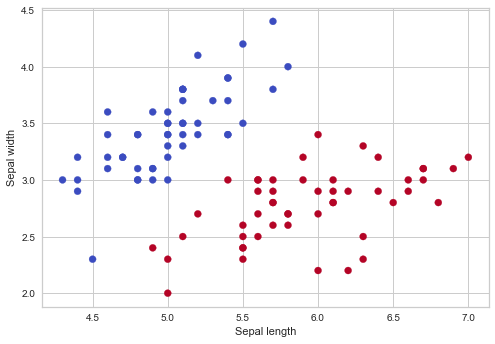

In [63]:
binary_y = [y_ for y_ in y if y_<2]
binary_X = X[:len(binary_y)]

plt.scatter(binary_X[:, 0], binary_X[:, 1], c=binary_y, cmap=plt.cm.coolwarm)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

Intuitively, a SVM will try to fit in hyperplanes (a flat affline surface, in a 2D context a line) that neatly classes and that have a distance to the nearest training data points of any class as large as possible, since in general the larger the distance (or margin) the lower the generalization error of the classifier. The nearest training data points, called the _support vectors_ are then the only points of interest for the regression. In our example above, the data is clearly linearly separable, as seen below:

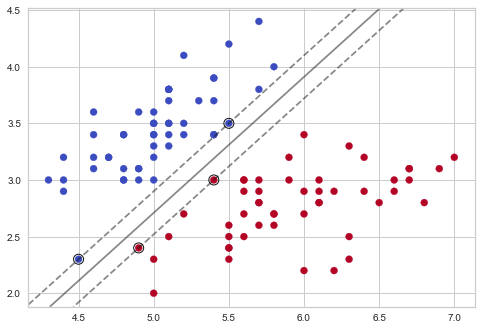

In [100]:
from sklearn import svm

# Hyperparameter
C=500

# Support Vector Classification
lin_svc = svm.LinearSVC(C=C, max_iter=1e6, loss='hinge').fit(binary_X, binary_y)

# Returns the decision function for each class in the model
decision_function = lin_svc.decision_function(binary_X)

# Find vectors that act as support
support_vector_indices = np.where(
    np.abs(decision_function) <= 1 + 1e-1)[0]

# Find to which observations this corresponds
support_vectors = binary_X[support_vector_indices]

# Simple scatter of our datapoints on two features
plt.scatter(binary_X[:, 0], binary_X[:, 1], c=binary_y, cmap=plt.cm.coolwarm)
# Get current axis instance
ax = plt.gca()

# Get axis x-y limits
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# meshgrid creates a rectangular grid out of two given arrays (x-y limits) representing the matrix indexing
xx, yy = np.meshgrid(
    np.linspace(xlim[0], xlim[1], 50), # linspaces creates an array that maps from point arg1 to point arg2 a total of arg3 points
    np.linspace(ylim[0], ylim[1], 50)
)

# Classification confidence score for each idx position in plot matrix 
Z = lin_svc.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Draw contour lines
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
            linestyles=['--', '-', '--'])

# Plot iris feature points
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100,
            linewidth=1, facecolors='none', edgecolors='k')

Note the use of C here. The parameter C, common to all SVM kernels we will see below, trades off misclassification of training data points against simplicity of the decision surface. A low C makes the decision surface smooth, which improves generalization, while a high C will attempt at classifying all training datapoints correctly. Proper choice of C is thus critical to the SVM's performance, and an optimal C is once again first found by using <code>GridSearchCV</code>. This can be seen more easily by moving onto a multi-class problem.

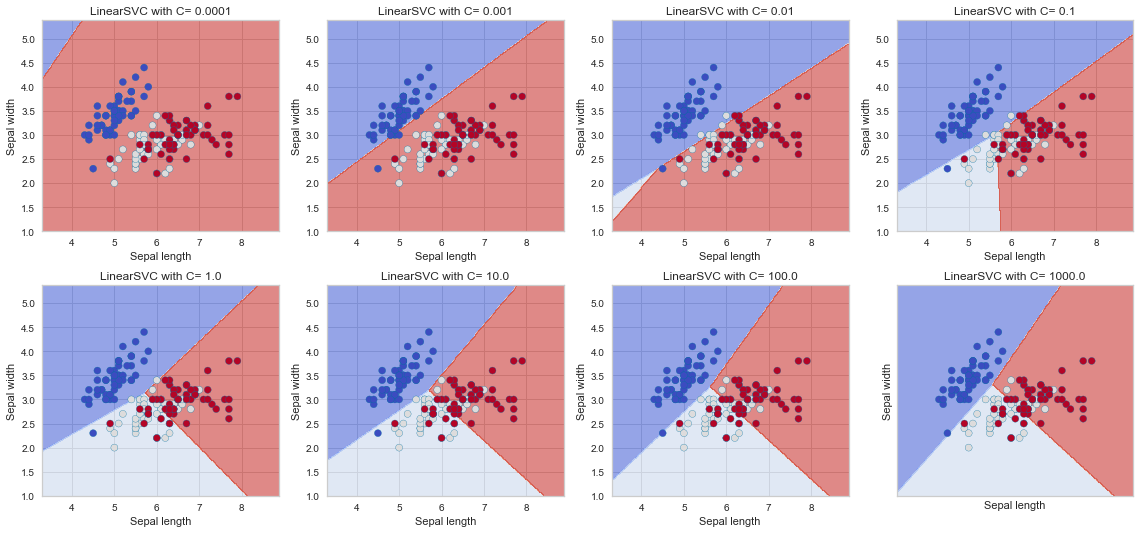

In [68]:
iris = load_iris()
X = iris.data[:, :2]
y = iris.target

C = np.logspace(-4,3,8)

# Meshgrid
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

fig, axes = plt.subplots(2, 4,figsize=(16,8), )

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
fig.tight_layout()

for i, ax in enumerate(axes.flatten()):
    
    C_i = C[i]
    lin_svc = svm.LinearSVC(C=C_i, max_iter=1e9).fit(X, y)
    Z = lin_svc.predict(np.c_[xx.ravel(), yy.ravel()])
    ax.set_title(f'LinearSVC with C= {C_i}')
    
    # Grid class assignment
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.6)
    
    # Plot also the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='b')
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.show()

To better understand how SVM and the parameter C works, let's briefly look at the optimization problem that a SVM with a linear kernel solves. Denoting our training vectors (sep len/width) $x_{i} \in \mathbb{R}^{n}$ and a vector of classes $y \in \{1,-1\}^n$, the problem lays in finding a norm of an hyperplane $w \in \mathbb{R}^b$ such that the prediction given by $sign\left(w^T\phi(x) + b\right)$ is correct for most samples, ie

$$
\min _{w, b} \frac{1}{2} w^{T} w+C \sum_{i=1} \max \left(0, y_{i}\left(w^{T} \phi\left(x_{i}\right)+b\right)\right)
$$

In words, we are trying to maximize the margin by minimizing the inner product $w^Tw$ (you maximize the $\frac{1}{||w||}$distance from a support vector $x_i$) while incurring a penalty when either the observation is misclassified or within the margin boundary. Here, C regulates the strength of this penalty, so that higher C values penalize misclassification more. Note that we use a linear kernel, but alternative kernels exist, as shown below.

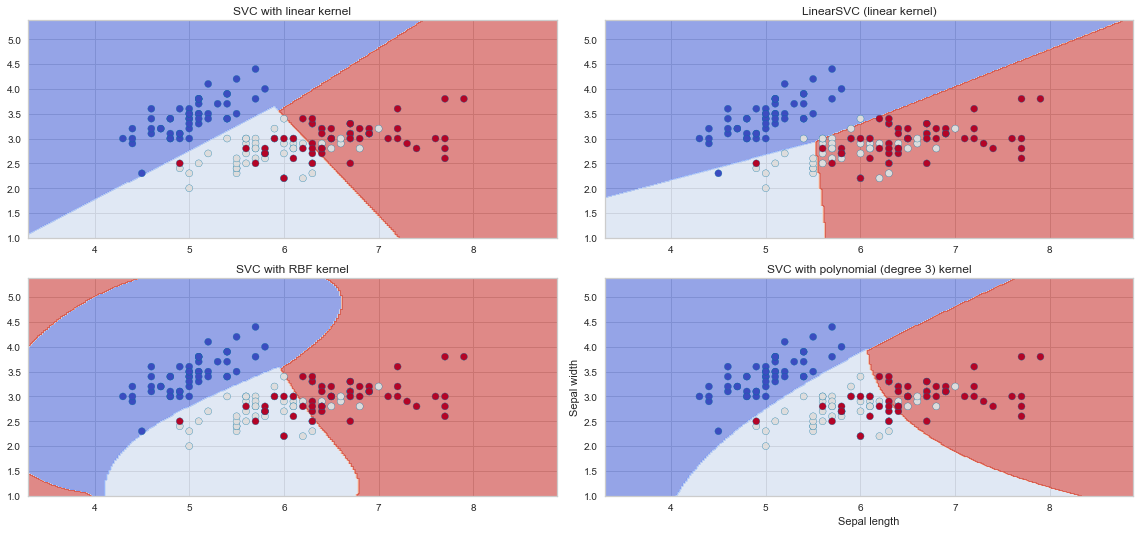

In [69]:
C = 1.0

# SVM models
svc = svm.SVC(kernel='linear', C=C).fit(X, y)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X, y)
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X, y)
lin_svc = svm.LinearSVC(C=C, max_iter=1e6, loss='hinge').fit(X, y)

# Meshgrid
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

titles = {
    0: {svc: 'SVC with linear kernel'},
    1: {lin_svc: 'LinearSVC (linear kernel)'},
    2: {rbf_svc: 'SVC with RBF kernel'},
    3: {poly_svc: 'SVC with polynomial (degree 3) kernel'}
}

fig, axes = plt.subplots(2, 2,figsize=(16,8))
fig.tight_layout()

for i, ax in enumerate(axes.flatten()):
    model_name = list(titles[i].keys())[0]
    
    Z = model_name.predict(np.c_[xx.ravel(), yy.ravel()])
        
    ax.set_title(titles[i][model_name])
    
    # Grid class assignment
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.6)
    
        # Plot also the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='b')
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.show()

#### Application to our news articles dataset

In [70]:
# Fine-tuning hyperparameters
grid = {'C': np.logspace(-1,2,4), 'loss': ['hinge', 'squared_hinge']}
model = svm.LinearSVC(max_iter=1e6)
model_cv = GridSearchCV(model, grid, cv=5)

model_cv.fit(X_train_mat,train_y)

model_cv.get_params()

{'cv': 5,
 'error_score': nan,
 'estimator__C': 1.0,
 'estimator__class_weight': None,
 'estimator__dual': True,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1,
 'estimator__loss': 'squared_hinge',
 'estimator__max_iter': 1000000.0,
 'estimator__multi_class': 'ovr',
 'estimator__penalty': 'l2',
 'estimator__random_state': None,
 'estimator__tol': 0.0001,
 'estimator__verbose': 0,
 'estimator': LinearSVC(max_iter=1000000.0),
 'iid': 'deprecated',
 'n_jobs': None,
 'param_grid': {'C': array([  0.1,   1. ,  10. , 100. ]),
  'loss': ['hinge', 'squared_hinge']},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'verbose': 0}

In [71]:
scikit_SVM = svm.LinearSVC(max_iter=1e6, C=model_cv.get_params()['estimator__C'], loss=model_cv.get_params()['estimator__loss'])

start = time.time()
model_SVM = scikit_SVM.fit(X_train_mat, train_y)
end = time.time()
svm_time = end - start
print(svm_time)

0.8451008796691895


In [72]:
svm_score = model_SVM.score(X_test_mat, test_y)
print('Accuracy of LinearSVC: %.3f' % svm_score)

Accuracy of LinearSVC: 0.960


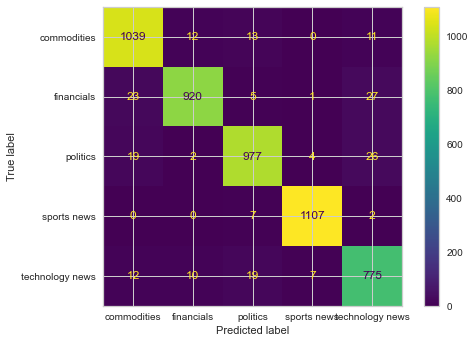

In [73]:
cm = confusion_matrix(test_y, model_SVM.predict(X_test_mat))
cmp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=model_SVM.classes_
)
cmp.plot()

In [74]:
from sklearn.metrics import classification_report

print(classification_report(test_y, model_SVM.predict(X_test_mat), target_names=model_SVM.classes_))

                 precision    recall  f1-score   support

    commodities       0.95      0.97      0.96      1075
     financials       0.97      0.94      0.96       976
       politics       0.96      0.95      0.95      1028
    sports news       0.99      0.99      0.99      1116
technology news       0.92      0.94      0.93       823

       accuracy                           0.96      5018
      macro avg       0.96      0.96      0.96      5018
   weighted avg       0.96      0.96      0.96      5018



In [75]:
test = "News of the corruption probe sent stock markets tumbling as the S&P 500 dropped 300 points in thirty minutes."

test = ' '.join(normalize_text(test))

test = tvec.transform([test]).todense()

model_SVM.predict(test)

array(['financials'], dtype=object)

In [76]:
test = "The screen is good for the money: fairly sharp, with good viewing angles, and bright enough indoors, though it struggles in direct sunlight. It also has Amazon’s integrated Alexa voice assistant."

test = ' '.join(normalize_text(test))

test = tvec.transform([test]).todense()

model_SVM.predict(test)

array(['technology news'], dtype=object)

In [77]:
test = "Southgate has ensured the defenders are well-drilled but what makes the England backline stand out is their communication and desire to play for one another. "

test = ' '.join(normalize_text(test))

test = tvec.transform([test]).todense()

model_SVM.predict(test)

array(['sports news'], dtype=object)

In [78]:
test = "When they poured across the border, I was cautioned to surrender, This I could not do, I took my gun and vanished."

test = ' '.join(normalize_text(test))

test = tvec.transform([test]).todense()

model_SVM.predict(test)

array(['financials'], dtype=object)

#### Feature relevance

In [80]:
for i, class_ in enumerate(model_SVM.classes_):
    top = model_SVM.coef_[i].argsort()[::-1][:20]
    wds = ' '.join([words[i] for i in top])
    print(f'Most relevant features for section {class_}: {wds}')

Most relevant features for section commodities: oil metal gold commod shell refineri gas import energi gasolin schmolling petroleum closur barrel trader soybean ton steel capac hudson
Most relevant features for section financials: nov coverag aug dec sept oct feb march text add june jan april index bank eikon newsroom properti may benchmark
Most relevant features for section politics: washington trump democrat donald republican senat obama secretari hous us presidenti affair iowa state defens shutdown ralli testifi immigr document
Most relevant features for section sports news: olymp race soccer team espn sport host cup championship bowl basketbal bodi season club champion dope formula golf nba leagu
Most relevant features for section technology news: network artifici digit uber cyber technolog chip mobil electron tech ecommerc smartphon comput onlin inc softwar telecom giant launch huawei


## 3 - Naive Bayes

Naive Bayes is a linear supervised learning method that applies Bayes' theorem on a space of features under the _naive_ assumption of conditional independence between these given the value of the class (or target) variable. Given a target variable $y$ and a feature vector running from $x_1$ to $x_N$, Naive Bayes solves the following posterior: 

$$
P\left(y \mid x_{1}, \ldots, x_{n}\right)=\frac{P(y) P\left(x_{1}, \ldots, x_{n} \mid y\right)}{P\left(x_{1}, \ldots, x_{n}\right)}
$$

where the assumption of conditional independence allows to simply rewrite the above as 

$$
P\left(y \mid x_{1}, \ldots, x_{n}\right)=\frac{P(y) \prod_{i=1}^{n} P\left(x_{i} \mid y\right)}{P\left(x_{1}, \ldots, x_{n}\right)} \propto P(y) \prod_{i=1}^{n} P\left(x_{i} \mid y\right)
$$

so that the optimization problem boils down to solving the following equation.

$$
\hat{y}=\arg \max _{y} P(y) \prod_{i=1}^{n} P\left(x_{i} \mid y\right)
$$

where we can use Maximum A Posteriori (MAP) estimation to compute $P(y)$ and $P\left(y \mid x_{i}\right)$, where the prior $P(y)$ simply becomes the relative frequency of class $y_i$ in $y$. Naive Bayes classifiers will then make one of several assumptions over the underlying distribution of the likelihood $P\left(y \mid x_{i}\right)$.

Despite its apparent simplicity, this generative model is one of the most widely used classifiers due to its ability to train well on small data and computational speed. Able to ignore any conditional distributions between features, each feature distribution is then assumed unidimensional, alleviating problems of the feature space being of similar size to the sample length. It is not without drawbacks, however, as its simplicity does mean it is less able to unearth more latent behavior in your feature space. 

Let's take a look at the binary sample of the iris dataset, where we try to classify observations using a **Gaussian Naive Bayes**:

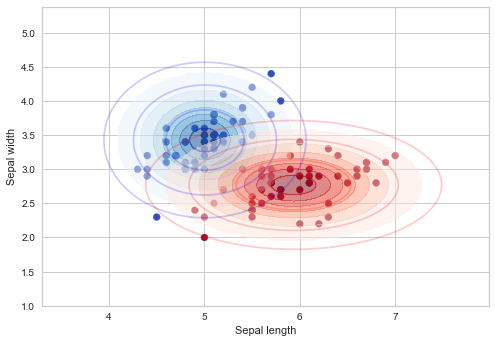

In [49]:
y2 = np.array(binary_y)
X2 = np.array(binary_X)

# Meshgrid
x_min, x_max = X2[:, 0].min() - 1, X2[:, 0].max() + 1
y_min, y_max = X2[:, 1].min() - 1, X2[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

Z = np.c_[xx.ravel(), yy.ravel()]

fig, ax = plt.subplots(1,1)
ax.scatter(X2[:, 0], X2[:, 1], c=y2, cmap=plt.cm.coolwarm, edgecolors='b')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

for i, flower in enumerate(['blue', 'red']):
    mask = (y2 == i)
    mu, std = X2[mask].mean(0), X2[mask].std(0)
    P = np.exp(-0.5 * (Z - mu) ** 2 / std ** 2).prod(1)
    Pm = np.ma.masked_array(P, P < 0.03)
    
    ax.contourf(xx, yy, Pm.reshape(xx.shape), cmap=flower.title() + 's', alpha=0.5)
    ax.contour(xx, yy, P.reshape(xx.shape),
           levels=[0.01, 0.1, 0.5, 0.9],
           colors=flower, alpha=0.2)

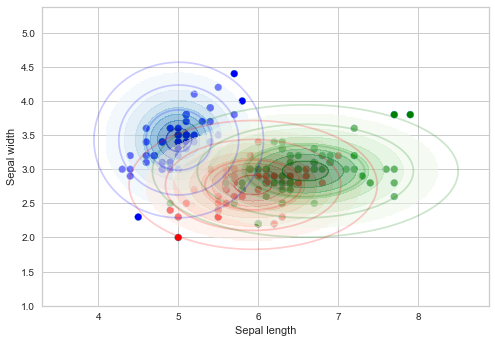

In [50]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['blue', 'red', 'green']
cmap = LinearSegmentedColormap.from_list('basic', colors, N=3)

y3 = np.array(y)
X3 = np.array(X)

# Meshgrid
x_min, x_max = X3[:, 0].min() - 1, X3[:, 0].max() + 1
y_min, y_max = X3[:, 1].min() - 1, X3[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

Z = np.c_[xx.ravel(), yy.ravel()]

fig, ax = plt.subplots(1,1)
ax.scatter(X3[:, 0], X3[:, 1], c=y3, cmap=cmap, edgecolors='b')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

for i, flower in enumerate(['blue', 'red', 'green']):
    mask = (y3 == i)
    mu, std = X[mask].mean(0), X[mask].std(0)
    P = np.exp(-0.5 * (Z - mu) ** 2 / std ** 2).prod(1)
    Pm = np.ma.masked_array(P, P < 0.03)
    
    ax.contourf(xx, yy, Pm.reshape(xx.shape), cmap=flower.title() + 's', alpha=0.5)
    ax.contour(xx, yy, P.reshape(xx.shape),
           levels=[0.01, 0.1, 0.5, 0.9],
           colors=flower, alpha=0.2)

The ellipses in the graphs above represent the Gaussian generative model for each flower type, with larger probability being given to the center of the ellipses. With this simple generative model in place, we can compute the likelihoods $P(x_i|y)$ for any data point and for any possible $y_i$, choosing to classify the new data point by taking the highest posterior probability of the lot.

Scikit-Learn's <code>sklearn.naive_bayes.GaussianNB</code> implements just such a method. In the case of our newspaper data, however, we clearly don't have normally distributed features, since these are transformed vectors of word counts. As such, these values can only be positive, and while not a count in its strict form, assuming a multinomial distribution for these parameters is more reasonable. 

In [81]:
from sklearn.naive_bayes import MultinomialNB

sklearn_NB = MultinomialNB()

In [82]:
from sklearn.model_selection import GridSearchCV

# Fine-tuning hyperparameters
grid = {'alpha': np.logspace(-1,0,5)}
model = MultinomialNB()
model_cv = GridSearchCV(model, grid, cv=5)

model_cv.fit(X_train_mat,train_y)

model_cv.get_params()

{'cv': 5,
 'error_score': nan,
 'estimator__alpha': 1.0,
 'estimator__class_prior': None,
 'estimator__fit_prior': True,
 'estimator': MultinomialNB(),
 'iid': 'deprecated',
 'n_jobs': None,
 'param_grid': {'alpha': array([0.1       , 0.17782794, 0.31622777, 0.56234133, 1.        ])},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'verbose': 0}

In [83]:
scikit_NB = MultinomialNB(alpha=model_cv.get_params()['estimator__alpha'])

start = time.time()
model_NB = scikit_NB.fit(X_train_mat, train_y)
end = time.time()

nb_time = end - start
nb_score = model_NB.score(X_test_mat, test_y)

In [84]:
print('Completion time of Naive Bayes: %.3f' % nb_time)
print('Accuracy of Naive Bayes: %.3f' % nb_score)

Completion time of Naive Bayes: 0.149
Accuracy of Naive Bayes: 0.941


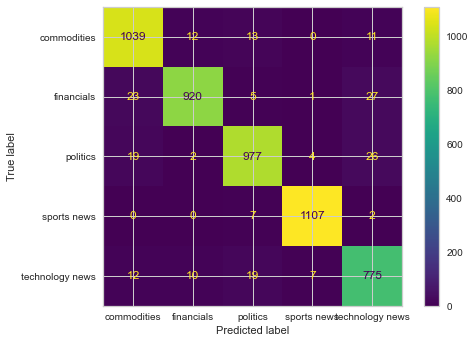

In [85]:
cm = confusion_matrix(test_y, model_SVM.predict(X_test_mat))
cmp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=model_SVM.classes_
)
cmp.plot()

In [86]:
print(classification_report(test_y, model_NB.predict(X_test_mat), target_names=model_NB.classes_))

                 precision    recall  f1-score   support

    commodities       0.93      0.97      0.95      1075
     financials       0.96      0.90      0.93       976
       politics       0.93      0.94      0.93      1028
    sports news       0.99      0.98      0.98      1116
technology news       0.88      0.91      0.90       823

       accuracy                           0.94      5018
      macro avg       0.94      0.94      0.94      5018
   weighted avg       0.94      0.94      0.94      5018



In [87]:
test = "News of the corruption probe sent stock markets tumbling as the S&P 500 dropped 300 points in thirty minutes."

test = ' '.join(normalize_text(test))

test = tvec.transform([test]).todense()

print(model_NB.predict(test))
model_NB.predict_proba(test)

['politics']


array([[0.18163478, 0.21811823, 0.26261235, 0.18420166, 0.15343297]])

In [88]:
test = "The screen is good for the money: fairly sharp, with good viewing angles, and bright enough indoors, though it struggles in direct sunlight. It also has Amazon’s integrated Alexa voice assistant."

test = ' '.join(normalize_text(test))

test = tvec.transform([test]).todense()

print(model_NB.predict(test))
model_NB.predict_proba(test)

['technology news']


array([[0.06784435, 0.01717429, 0.22723217, 0.14414619, 0.54360301]])

In [89]:
test = "Southgate has ensured the defenders are well-drilled but what makes the England backline stand out is their communication and desire to play for one another. "

test = ' '.join(normalize_text(test))

test = tvec.transform([test]).todense()

print(model_NB.predict(test))
model_NB.predict_proba(test)

['sports news']


array([[0.01386806, 0.01157689, 0.08713123, 0.80581288, 0.08161094]])

In [90]:
test = "When they poured across the border, I was cautioned to surrender, This I could not do, I took my gun and vanished."

test = ' '.join(normalize_text(test))

test = tvec.transform([test]).todense()

print(model_NB.predict(test))
model_NB.predict_proba(test)

['politics']


array([[0.16471494, 0.0425601 , 0.57788732, 0.10192796, 0.11290968]])

#### Feature relevance

In [91]:
for i, class_ in enumerate(model_NB.classes_):
    top = model_NB.coef_[i].argsort()[::-1][:20]
    wds = ' '.join([words[i] for i in top])
    print(f'Most relevant features for section {class_}: {wds}')

Most relevant features for section commodities: oil price gas product china million crude tonn year percent compani energi export barrel produc mine market import suppli us
Most relevant features for section financials: coverag text bank sourc compani million eikon ltd newsroom percent billion share versus euro gdynia net say profit co year
Most relevant features for section politics: trump us hous democrat republican senat presid washington state would white report elect campaign donald vote bill committe tax administr
Most relevant features for section sports news: game team olymp play season world win first player second open point champion one sport race match year final time
Most relevant features for section technology news: compani technolog billion china servic inc million report market year firm share new use network percent data invest busi facebook


## 4 - Random Forest

Random Forests have gained a lot of traction in recent years due to their intuitive yet powerful behavior in discerning which classes observations belong to. It is an example of an _ensemble_ method, in that it relies on aggregating the results of an ensemble of simpler estimators. Not surprisingly, these singular estimators are called **decision trees**. The trick lays in that while decision trees may do a good job at classifying training data, the choice of variables they use to do so may change from iteration to iteration (you can think of these being somewhat colinear). Additionally, as we fine-grain our decision process, a decision tree algorithm will tend to overfit, as it will increasingly find splits of the data that are not easily generalized to other samples. Random forests are used to address these two shortfalls, by **(i)** using a majority vote over features and classifications and **(ii)** randomly averaging over trees to even out tree-specific over-fitting. 

#### Decision tree

Decision trees are simply objects designed to zero-in on the classification. If we were to collect weather data to classify a given day as $P$ or $N$ (say, decide to go out on a walk), we would simply use the data to construct a decision tree similar to the one below.

<div style="text-align:center">
<img src="figs/decisiontree.png" alt="decisiontree" style="height: 300px; width:500px;"/>
</div>


The binary splitting makes this decision particularly efficient, which enables random forests to work well with highly dimensional data by allowing an algorithm to quickly narrow down class probabilities given certain features. However, the choice of features, particularly in sparse data like in our tf-idf matrix, begs the question of which variables (words) to cut on. We will ge there, but let's first take a quick look at our iris data using a decision tree. Let's consider the three types of flower and their sepal width and length. 

Text(0, 0.5, 'Sepal width')

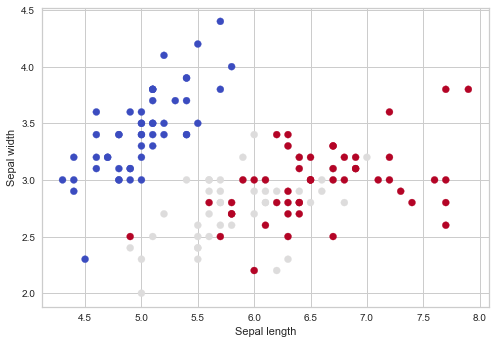

In [92]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

Text(0.5, 1.0, 'Decision Tree Classification at Depth=3')

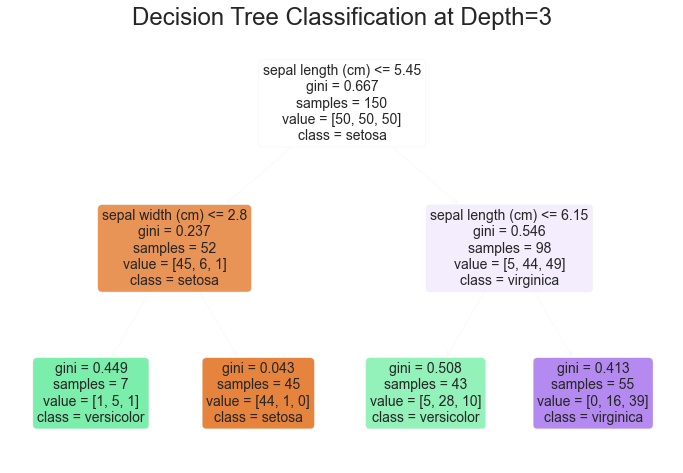

In [93]:
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier

model_DT = DecisionTreeClassifier(max_depth=2).fit(X, y)

fig = plt.figure(figsize=(12, 8))
fig = plot_tree(model_DT, 
          feature_names=iris.feature_names,
          class_names=iris.target_names, 
          filled=True, impurity=True, 
          rounded=True)
plt.title('Decision Tree Classification at Depth=3', fontdict={'fontsize': 24})

A decision tree then will iteratively split the data along either of the axis according to some quantitative criterion (for details, see [here](https://scikit-learn.org/stable/modules/tree.html#mathematical-formulation)). Scikit-Learn's <code>DecisionTreeClassifier</code> can be used to implement trees.

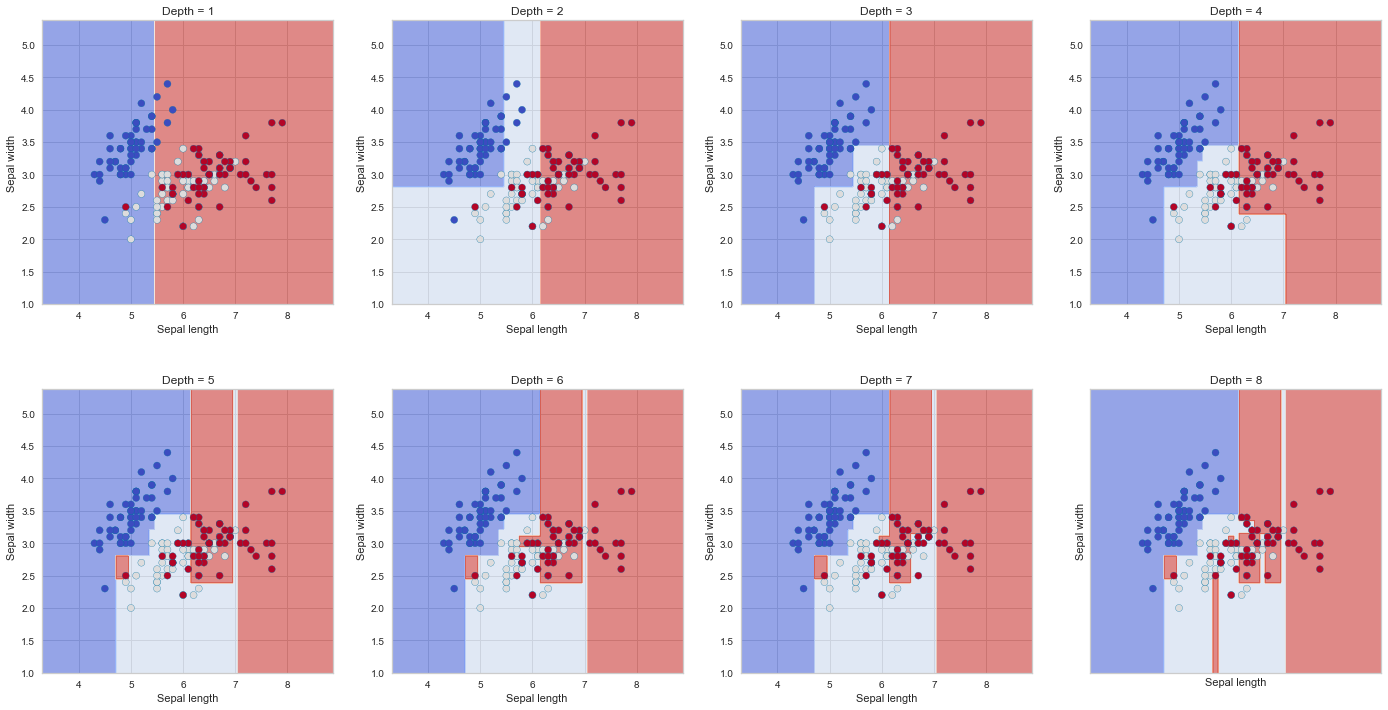

In [124]:
X = iris.data[:, :2]
y = iris.target

# Meshgrid
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

fig, axes = plt.subplots(2, 4,figsize=(24,12), gridspec_kw={'hspace': 0.3})

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

for i, ax in enumerate(axes.flatten()):
    depth = i+1
    ax.set_title(f'Depth = {depth}')
    model_DT = DecisionTreeClassifier(max_depth=depth).fit(X, y)
    Z = model_DT.predict(np.c_[xx.ravel(), yy.ravel()])
    # Grid class assignment
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.6)
    
    # Plot also the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='b')
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')

Notice that as the depth of the decision tree increases, so does the number of color strips that result from the increasingly fine-grained splits. This over-fitting harms the model's ability to classify yet-unseen data, and a solution is to build trees from random samples in our data in the hopes that combining multiple overfitting estimators will reduce overall overfitting. In Machine Learning this is known as _bagging_, ensemble methods that use a group of parallel estimators and averages their overfitted results to improve classification. In our context, an ensemble of randomized decision trees is known as a random forest. 

In [125]:
from sklearn.ensemble import BaggingClassifier

model_DT = DecisionTreeClassifier(max_depth=4)

bag = BaggingClassifier(
    model_DT, 
    n_estimators=100, 
    max_samples=0.8,
    random_state=42
)

bag.fit(X, y)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=4),
                  max_samples=0.8, n_estimators=100, random_state=42)

The model above samples 80% of our data for each decision tree, and the results below show that indeed our estimations are somewhat more robust to outliers.

Text(0, 0.5, 'Sepal width')

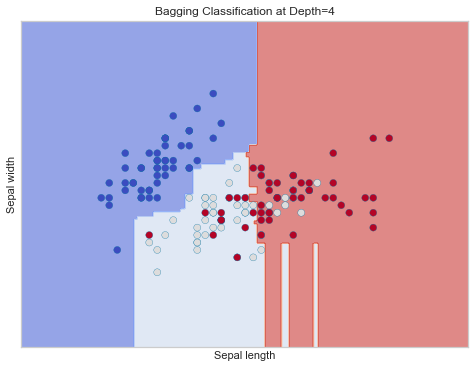

In [126]:
# Meshgrid
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

fig, ax = plt.subplots(1, 1, figsize=(8,6))
plt.title('Bagging Classification at Depth=4', fontdict={'fontsize': 12})

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

Z = bag.predict(np.c_[xx.ravel(), yy.ravel()])
# Grid class assignment
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.6)

# Plot also the training points
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='b')
ax.set_xlabel('Sepal length')
ax.set_ylabel('Sepal width')

We are not yet out of the woods, however, since the sequential behavior of the splits over the features can be shown to limit the algorithm's predictive power when the feature space is larger than 2. This follows from the debate on over-fitting and the attempt at reducing correlation between trees as much as possible by bagging. In the case some feature was predominantly relevant in our data would lead our trees to somewhat correlate with eachother, as their initial split will tend to be on the same feature. As such, it is standard in the literature to also shuffle and select a subset of features to split on in each tree. This is a key component of a random forest, and it's the kind of optimized behavior that Scikit-Learn implements in their <code>sklearn.ensemble.RandomForestClassifier</code> module. Let us now try it on our newspaper data.

### Newspaper data

Text(0.5, 1.0, 'Decision Tree Classification at Depth=4')

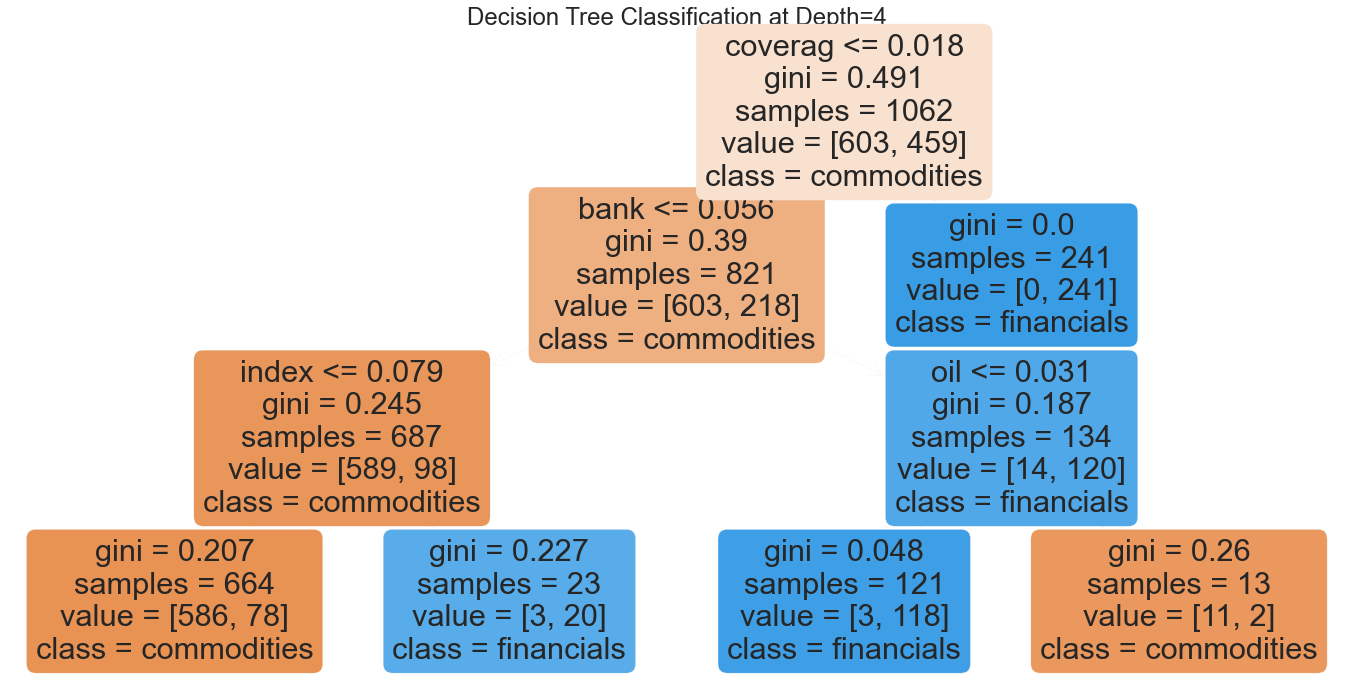

In [138]:
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier

model_DT = DecisionTreeClassifier(max_depth=3).fit(X_train_mat, train_y)

fig = plt.figure(figsize=(24, 12))
fig = plot_tree(model_DT, 
          feature_names=words,
          class_names=model_DT.classes_, 
          filled=True, impurity=True, 
          rounded=True)
plt.title('Decision Tree Classification at Depth=4', fontdict={'fontsize': 24})

In [99]:
from sklearn.ensemble import RandomForestClassifier
grid = {'n_estimators': [100, 200], 'max_depth': list(range(1,8))}
model_cv = GridSearchCV(RandomForestClassifier(), param_grid=grid, cv=2)
model_cv.fit(X_train_mat,train_y)

model_cv.get_params()

{'cv': 2,
 'error_score': nan,
 'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': 'auto',
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': None,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestClassifier(),
 'iid': 'deprecated',
 'n_jobs': None,
 'param_grid': {'n_estimators': [100, 200],
  'max_depth': [1, 2, 3, 4, 5, 6, 7]},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'verbose': 0}

In [101]:
scikit_RF = RandomForestClassifier(
    n_estimators=model_cv.get_params()['estimator__n_estimators'],
    max_depth=model_cv.get_params()['estimator__max_depth'],
)

start = time.time()
model_RF = scikit_RF.fit(X_train_mat, train_y)
end = time.time()

RF_time = end - start

In [102]:
RF_score = model_RF.score(X_test_mat, test_y)
print('Accuracy of RandomForest: %.3f' % RF_score)

Accuracy of RandomForest: 0.946


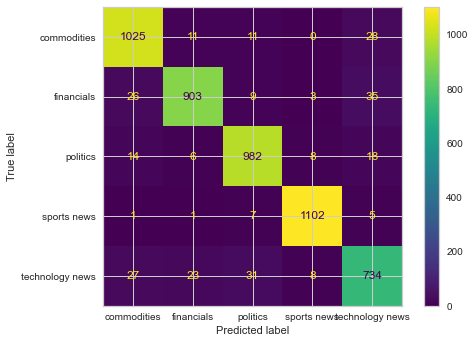

In [103]:
cm = confusion_matrix(test_y, model_RF.predict(X_test_mat))
cmp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=model_RF.classes_
)
cmp.plot()

In [104]:
from sklearn.metrics import classification_report

print(classification_report(test_y, model_RF.predict(X_test_mat), target_names=model_RF.classes_))

                 precision    recall  f1-score   support

    commodities       0.94      0.95      0.95      1075
     financials       0.96      0.93      0.94       976
       politics       0.94      0.96      0.95      1028
    sports news       0.98      0.99      0.99      1116
technology news       0.90      0.89      0.89       823

       accuracy                           0.95      5018
      macro avg       0.94      0.94      0.94      5018
   weighted avg       0.95      0.95      0.95      5018



In [105]:
test = "News of the corruption probe sent stock markets tumbling as the S&P 500 dropped 300 points in thirty minutes."

test = ' '.join(normalize_text(test))

test = tvec.transform([test]).todense()

model_RF.predict(test)

array(['financials'], dtype=object)

In [106]:
test = "The screen is good for the money: fairly sharp, with good viewing angles, and bright enough indoors, though it struggles in direct sunlight. It also has Amazon’s integrated Alexa voice assistant."

test = ' '.join(normalize_text(test))

test = tvec.transform([test]).todense()

model_RF.predict(test)

array(['financials'], dtype=object)

In [107]:
test = "Southgate has ensured the defenders are well-drilled but what makes the England backline stand out is their communication and desire to play for one another. "

test = ' '.join(normalize_text(test))

test = tvec.transform([test]).todense()

model_RF.predict(test)

array(['financials'], dtype=object)

In [108]:
test = "When they poured across the border, I was cautioned to surrender, This I could not do, I took my gun and vanished."

test = ' '.join(normalize_text(test))

test = tvec.transform([test]).todense()

model_RF.predict(test)

array(['financials'], dtype=object)

## Final comparison

In [109]:
models_dict = {}

# Add to dictionary
models_dict['Logit with L1'] = tuple([logit_l1_time, logit_l1_score])
models_dict['Logit with L2'] = tuple([logit_l2_time, logit_l2_score])
models_dict['Logit with Elastic Net'] = tuple([logit_ela_time, logit_ela_score])
models_dict['Support Vector Machine'] = tuple([svm_time, svm_score])
models_dict['Naive Bayes'] = tuple([nb_time, nb_score])
models_dict['Random Forest'] = tuple([RF_time, RF_score])

In [110]:
for item in models_dict:
    time = round(models_dict[item][0],2)
    acc = round(models_dict[item][1],4)
    print(f'Model: {item:{24}} ----- Training time: {time:{6}} seconds ----- Accuracy: {acc:{4}}')

Model: Logit with L1            ----- Training time: 119.32 seconds ----- Accuracy: 0.9603
Model: Logit with L2            ----- Training time:  20.59 seconds ----- Accuracy: 0.9574
Model: Logit with Elastic Net   ----- Training time:  51.16 seconds ----- Accuracy: 0.9582
Model: Support Vector Machine   ----- Training time:   0.85 seconds ----- Accuracy: 0.9601
Model: Naive Bayes              ----- Training time:   0.15 seconds ----- Accuracy: 0.9406
Model: Random Forest            ----- Training time:   27.6 seconds ----- Accuracy: 0.9458


# Random Forest Regression

### Train, test samples

In [111]:
reuters_df = reuters_df.loc[(reuters_df.section=='commodities')|(reuters_df.section=='financials')]
reuters_df['date'] = pd.to_datetime(reuters_df['date'])

reuters_df['day_content'] = reuters_df.groupby('date')['preproc'].transform(lambda x: ','.join(x))
reuters_df.drop_duplicates(subset=['date'], inplace=True)

financials = reuters_df[['date','day_content']].sort_values(by=['date'])

In [112]:
#load sp500 data
sp500 = pd.read_csv(datadir / 'sp500.csv')
sp500['date'] = pd.to_datetime(sp500['Date'])

In [113]:
financials = pd.merge(financials, sp500[['Close/Last','date']], on='date', how='inner')
financials = financials.loc[financials.date<'2019-06-01']

In [114]:
financials

date                                        day_content  Close/Last
0   2016-07-07  singaporeseoultokyo half year strong oil price...     2097.90
1   2016-07-08  shanghai china centralgovern run steel coal fi...     2129.90
2   2016-07-11  juli aroundtown properti hold plc success plac...     2137.16
3   2016-07-12  pragu juli health itali bank may bigger proble...     2152.14
4   2016-07-13  tbilisi fund manag advisori compani infrapartn...     2152.43
..         ...                                                ...         ...
720 2019-05-24  moscow may russia largest lender sberbank read...     2826.06
721 2019-05-28  oslo oil gas compani work norway hike invest f...     2802.39
722 2019-05-29  mexico citi mexican attorney general offic lat...     2783.02
723 2019-05-30  bogota least twentytwo compani qualifi bid new...     2788.86
724 2019-05-31  new delhibengaluru global mine conglomer vedan...     2752.06

[725 rows x 3 columns]

In [115]:
# train_test_split returns two dataframes
# fin_train_df, fin_test_df = train_test_split(financials, random_state=42, test_size=0.2)

fin_train_df = financials[:600]
fin_test_df = financials[600:]

train_x = fin_train_df['day_content']
test_x = fin_test_df['day_content']

train_y = fin_train_df['Close/Last']
test_y = fin_test_df['Close/Last']

### Feature weighting

In [116]:
tvec = TfidfVectorizer()

train_data_tfidf = tvec.fit_transform(train_x)     # Train and transform  
test_data_tfidf = tvec.transform(test_x)

X_train_mat = train_data_tfidf.todense()           # Output in dense format
X_test_mat = test_data_tfidf.todense()             # Output in dense format

words = tvec.get_feature_names()                   # Store word names

# Data snippet
x_train_df = pd.DataFrame(X_train_mat)
x_train_df.columns = words
x_train_df.head(2)

000852sz  001p  002285sz  002353sz  002460sz  002466sz  0039hk  010  \
0       0.0   0.0       0.0       0.0       0.0       0.0     0.0  0.0   
1       0.0   0.0       0.0       0.0       0.0       0.0     0.0  0.0   

   010increas  013  0176  0196hk  01oq  0291hk   03  036per  051b  051c   06  \
0         0.0  0.0   0.0     0.0   0.0     0.0  0.0     0.0   0.0   0.0  0.0   
1         0.0  0.0   0.0     0.0   0.0     0.0  0.0     0.0   0.0   0.0  0.0   

   06524shr  06bcfd  06percent  08percent   09  0912bn  0basebwshmet  0bl2  \
0       0.0     0.0        0.0        0.0  0.0     0.0           0.0   0.0   
1       0.0     0.0        0.0        0.0  0.0     0.0           0.0   0.0   

    0c  0cl  0com  0ema  0isc  0lco  0lmewhc  0lmewhl  0mznstxlocgr  0ncfm  \
0  0.0  0.0   0.0   0.0   0.0   0.0      0.0      0.0           0.0    0.0   
1  0.0  0.0   0.0   0.0   0.0   0.0      0.0      0.0           0.0    0.0   

    0s  0scf  0slnf  0smmalinv  0sxnp  0szzf  0x9me7yboc  100  100000tonn  \
0  0.0   0.0    0.0        0.0    0.0    0.0         0.0  0.0         0.0   
1  0.0   0.0    0.0        0.0    0.0    0.0         0.0  0.0         0.0   

   100000tpi  1000foot  1000m  1000mw  1000oz  1000rupe  100150m  1006  \
0        0.0       0.0    0.0     0.0     0.0       0.0      0.0   0.0   
1        0.0       0.0    0.0     0.0     0.0       0.0      0.0   0.0   

   100abarrel  100bp  100day  100km  100millioncubicmetr  100millioneuro  \
0         0.0    0.0     0.0    0.0                  0.0             0.0   
1         0.0    0.0     0.0    0.0                  0.0             0.0   

   100pct  100percent  100th  100ton  100yuan  1019am  102  1029pct  103  \
0     0.0         0.0    0.0     0.0      0.0     0.0  0.0      0.0  0.0   
1     0.0         0.0    0.0     0.0      0.0     0.0  0.0      0.0  0.0   

   103year  104000tonn  10426m  104percent  1055pct  106  1063foot  \
0      0.0         0.0     0.0         0.0      0.0  0.0       0.0   
1      0.0         0.0     0.0         0.0      0.0  0.0       0.0   

   106percent  109  1093m  109year  10bb  10bps  10day  10fold  10m  10member  \
0         0.0  0.0    0.0      0.0   0.0    0.0    0.0     0.0  0.0       0.0   
1         0.0  0.0    0.0      0.0   0.0    0.0    0.0     0.0  0.0       0.0   

   10month  10pct  10percent  10ppm  10premium  10reuter  10th  10year  110  \
0      0.0    0.0        0.0    0.0        0.0       0.0   0.0     0.0  0.0   
1      0.0    0.0        0.0    0.0        0.0       0.0   0.0     0.0  0.0   

   1100  110000bushel  1100mile  110kg  110percent  1113bn  1125bp  11283m  \
0   0.0           0.0       0.0    0.0         0.0     0.0     0.0     0.0   
1   0.0           0.0       0.0    0.0         0.0     0.0     0.0     0.0   

   112millioneuro  112month  1130am  114  1147kilomet  114bn  115000bpd  \
0             0.0       0.0     0.0  0.0          0.0    0.0        0.0   
1             0.0       0.0     0.0  0.0          0.0    0.0        0.0   

   115cr00867  116  1172mile  1176  1180mile  118cv00182  118cv4148  \
0         0.0  0.0       0.0   0.0       0.0         0.0        0.0   
1         0.0  0.0       0.0   0.0       0.0         0.0        0.0   

   11billion  11day  11km  11m  11million  11milliontonn  11month  11percent  \
0        0.0    0.0   0.0  0.0        0.0            0.0      0.0        0.0   
1        0.0    0.0   0.0  0.0        0.0            0.0      0.0        0.0   

   11reuter  11th  11trillioneuro  11week  11year   12  12000mile  120m  \
0       0.0   0.0             0.0     0.0     0.0  0.0        0.0   0.0   
1       0.0   0.0             0.0     0.0     0.0  0.0        0.0   0.0   

   1225bn  123bp125bp  125  1250  1250strong  1251hk  125bp  125mile  1261m  \
0     0.0         0.0  0.0   0.0         0.0     0.0    0.0      0.0    0.0   
1     0.0         0.0  0.0   0.0         0.0     0.0    0.0      0.0    0.0   

   1275bn  1280megawatt  1288hk  129000squar  1290km  12bps  12cent  12day  \
0    

### Parameter fine-tuning

In [118]:
from sklearn.ensemble import RandomForestRegressor

In [85]:
grid = {'n_estimators': [100, 200], 'max_depth': list(range(1,3))}
model_cv = GridSearchCV(RandomForestRegressor(), param_grid=grid, cv=2)
model_cv.fit(X_train_mat,train_y)

model_cv.get_params()

{'cv': 2,
 'error_score': nan,
 'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'mse',
 'estimator__max_depth': None,
 'estimator__max_features': 'auto',
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': None,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestRegressor(),
 'iid': 'deprecated',
 'n_jobs': None,
 'param_grid': {'n_estimators': [100, 200], 'max_depth': [1, 2, 3, 4]},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'verbose': 0}

### Regression

In [119]:
scikit_RF = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
)

model_RF = scikit_RF.fit(X_train_mat, train_y)

In [120]:
train_y_pred = model_RF.predict(X_train_mat)
test_y_pred = model_RF.predict(X_test_mat)

<AxesSubplot:xlabel='date', ylabel='Close/Last'>

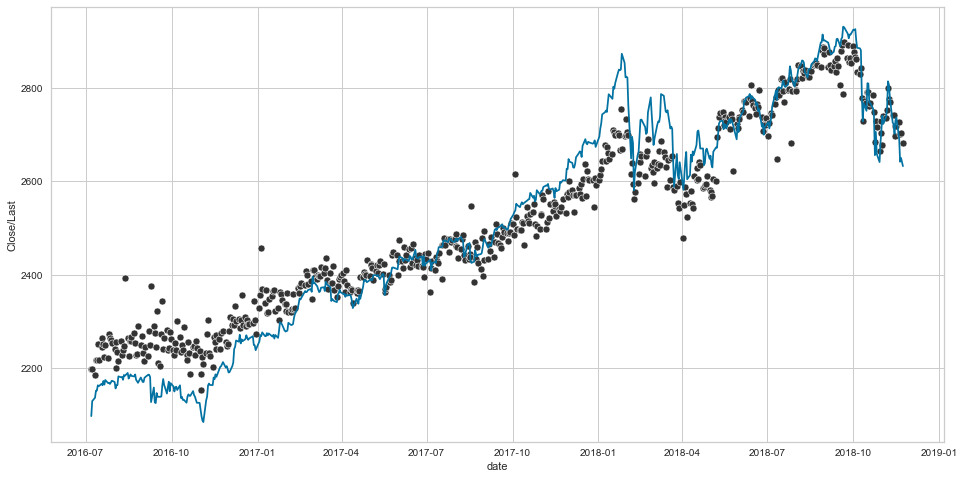

In [121]:
fig, axes = plt.subplots(1, 1,figsize=(16,8))

sns.lineplot(x=fin_train_df['date'], y=fin_train_df['Close/Last'])
sns.scatterplot(x=fin_train_df['date'], y=train_y_pred, color='.2')

<AxesSubplot:xlabel='date', ylabel='Close/Last'>

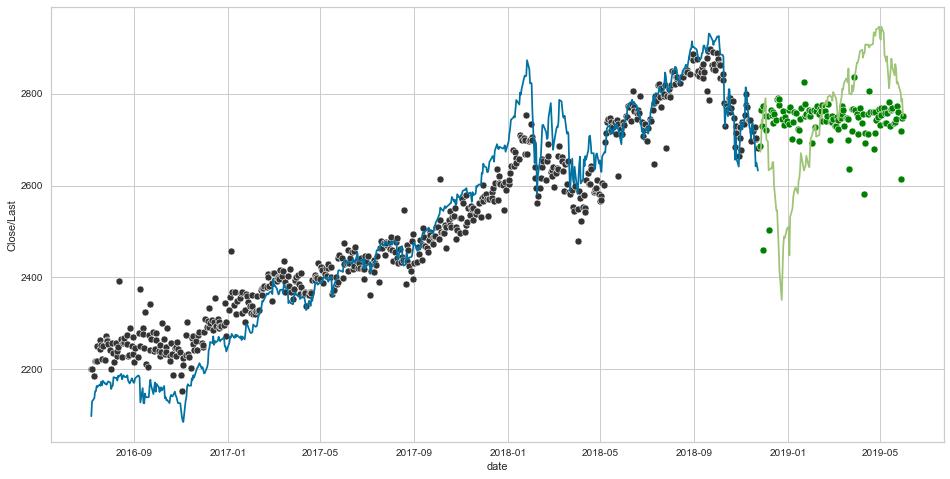

In [122]:
fig, axes = plt.subplots(1, 1,figsize=(16,8))

sns.lineplot(x=fin_train_df['date'], y=fin_train_df['Close/Last'])
sns.lineplot(x=fin_test_df['date'], y=fin_test_df['Close/Last'])

sns.scatterplot(x=fin_train_df['date'], y=train_y_pred, color='.2')
sns.scatterplot(x=fin_test_df['date'], y=test_y_pred, color='green')

For a good academic application of such techniques, have a look at [this paper](https://www.sciencedirect.com/science/article/pii/S0304405X16301751) by Manela and coauthors from 2017.

## Beyond: Predicting authorship of The Hill articles

In [91]:
thehill_df = pd.read_csv(
    datadir / 'thehill_news.csv',
    usecols=COLS,
    dtype=TYPES
)

thehill_df['words'] = reuters_df.article.str.len()

In [92]:
thehill_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13983 entries, 0 to 13982
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         13983 non-null  object 
 1   author       13983 non-null  object 
 2   title        13983 non-null  object 
 3   article      13983 non-null  object 
 4   section      0 non-null      object 
 5   publication  13983 non-null  object 
 6   words        1238 non-null   float64
dtypes: float64(1), object(6)
memory usage: 764.8+ KB


In [93]:
thehill_df.author.value_counts()

John Bowden          2200
Rebecca Savransky    1819
Julia Manchester     1721
Jordain Carney       1363
Max Greenwood        1356
Brett Samuels        1173
Mark Hensch          1168
Tal Axelrod          1123
Joe Concha           1069
Zack Budryk           991
Name: author, dtype: int64